In [1]:
from IPython.display import Audio
import IPython
def progress(value, max=100):
    return IPython.display.HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
plt.style.use('seaborn')
tf.test.gpu_device_name()

'/device:GPU:0'

# Load database

In [47]:
samplerate=400
label_name="THREE_P1" #'TWO' , 'THREE_P1' , 'THREE_P2' , 'THREE_RESHAPE'


typee="x"
name=label_name+"_"+typee
dataframe_x=pd.read_csv ("../datasets/{}_data_sample_{}.csv".format(name,samplerate),header=None)

dataframe_x['x']=dataframe_x[samplerate]
dataframe_x['y']=dataframe_x[samplerate+1]
dataframe_x['z']=dataframe_x[samplerate+2]
dataframe_x=dataframe_x.drop([samplerate, samplerate+1,samplerate+2], axis=1)

y = pd.DataFrame({'x':dataframe_x['x'],
              'y': dataframe_x['y'],
              'z': dataframe_x['z']})
dataframe_x=dataframe_x.drop(['x', 'y','z'], axis=1)

typee="y"
name=label_name+"_"+typee
dataframe_y=pd.read_csv ("../datasets/{}_data_sample_{}.csv".format(name,samplerate),header=None)
dataframe_y=dataframe_y.drop([samplerate, samplerate+1,samplerate+2], axis=1)

typee="z"
name=label_name+"_"+typee
dataframe_z=pd.read_csv ("../datasets/{}_data_sample_{}.csv".format(name,samplerate),header=None)
dataframe_z=dataframe_z.drop([samplerate, samplerate+1,samplerate+2], axis=1)

dataframe=pd.concat([dataframe_x,dataframe_y,dataframe_z],axis=1)
dataframe.columns = list(range(samplerate*3))

x_train, x_test, y_train, y_test = train_test_split(dataframe, y,random_state=11, test_size=0.2,shuffle=True)
x_train_x,x_train_y,x_train_z=[],[],[]
x_test_x,x_test_y,x_test_z=[],[],[]
X_train=x_train.iloc[:,:].values
X_test=x_test.iloc[:,:].values

for i in range(len(x_train)):
    x_train_x.append(X_train[i][0:samplerate])
    x_train_y.append(X_train[i][samplerate:samplerate*2])
    x_train_z.append(X_train[i][samplerate*2:samplerate*3])
X_train_x=np.array(x_train_x)
X_train_y=np.array(x_train_y)
X_train_z=np.array(x_train_z)

for i in range(len(x_test)):
    x_test_x.append(X_test[i][0:samplerate])
    x_test_y.append(X_test[i][samplerate:samplerate*2])
    x_test_z.append(X_test[i][samplerate*2:samplerate*3])  

X_test_x=np.array(x_test_x)
X_test_y=np.array(x_test_y)
X_test_z=np.array(x_test_z)

In [24]:
#model_name_to_load='sixthcase_study_singlesensor_y'
#model_name_to_load='fifthcase_study_y_direction'
#model_name_to_load='fifthcase_study_firstdatabase_y'
#model_name_to_load='final_case_study_Three_P1_y'
#model_name_to_load='final_case_study_Three_P2_y'
model_name_to_load='final_case_study_Three_reshape_z'
typeofmodel='1D' #1D or 2D
model_name_to_load=typeofmodel+'_'+model_name_to_load
base_model=tf.keras.models.load_model('{}/best_model.h5'.format(model_name_to_load))
base_model.trainable = False


testdataframe=pd.read_csv ("{}/test_{}.csv".format(model_name_to_load,samplerate)) 
traindataframe=pd.read_csv ("{}/train_{}.csv".format(model_name_to_load,samplerate)) 
y_test_h = pd.DataFrame({'x':testdataframe['x'],
              'y': testdataframe['y'],
              'z': testdataframe['z']})
X_test_h=testdataframe.drop(['x', 'y','z'], axis=1)
y_train_h = pd.DataFrame({'x':traindataframe['x'],
              'y': traindataframe['y'],
              'z': traindataframe['z']})
X_train_h=traindataframe.drop(['x', 'y','z'], axis=1)
print("Input shape:",base_model.get_config()["layers"][0]["config"]["batch_input_shape"])
base_model.summary()

Input shape: (None, 400, 1)
Model: "1D_final_case_study_three_reshape_z"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 400, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 394, 64)           512       
_________________________________________________________________
average_pooling1d_2 (Average (None, 98, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 89, 256)           164096    
_________________________________________________________________
ave

In [25]:
print("Evaluate on test data wich trained by")
results =base_model.evaluate(X_test_h, y_test_h, batch_size=4,verbose=2)
print("Evaluate on test new DB")
results =base_model.evaluate(X_test_y, y_test, batch_size=4,verbose=2)

Evaluate on test data wich trained by
35/35 - 1s - loss: 31147.8867 - mean_squared_error: 30306.8105
Evaluate on test new DB
35/35 - 1s - loss: 57691.9062 - mean_squared_error: 56850.8242


# Create model

In [26]:
model_name_to_save='final_case_study_Three_reshape_z_triple'

import os
from pathlib import Path
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

typeofmodel='1D'
model_name_to_save=typeofmodel+'_'+model_name_to_save
his_file = Path(model_name_to_save)
if his_file.exists():
    print('folder exist')
    his_file = Path("{}/history.csv".format(model_name_to_save))
    if his_file.exists():
        os.remove("{}/history.csv".format(model_name_to_save))
else:
    os.mkdir(model_name_to_save)

im_shape=(X_train_x.shape[1])


inputdata_x=tf.keras.Input(im_shape)
inputdata_y=tf.keras.Input(im_shape)
inputdata_z=tf.keras.Input(im_shape)


config1={'av1':2,'av2':3,'unit1': 32, 'unit2': 256, 'kernel1': 8, 'kernel2': 4,'drop1':0.3,'drop2':0.4, 'dense_size1': 287, 'dense_size2': 179, 'dense_size3': 405,"r1":0.1,"r2":0.1,"r3":0.1,"r4":0.1,"r5":0.1}

def build_1D_model(config):
    added=tf.concat([inputdata_x,inputdata_y,inputdata_z], 1)
    added=tf.reshape(added,[-1,1200,1])
    added=layers.Convolution1D(10, (64), activation="relu",kernel_regularizer=l2(0.2), input_shape=(X_train_x.shape[1],1) )(added)
    added=layers.MaxPooling1D(7)(added)
    added=layers.Flatten()(added)
    added=layers.Dense(400, activation="relu",kernel_regularizer=l2(0.1),name="embedded")(added)
    added=layers.Dropout(0.2)(added)
    
    output=base_model(added,training=False)
    
    model=Model(inputs=[inputdata_x,inputdata_y,inputdata_z],outputs=output,name=model_name_to_save)


    losses=tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
    metric=[tf.keras.metrics.MeanSquaredError()]
    
    model.compile(optimizer='nadam', loss=losses ,metrics = metric)
    return model 

model=build_1D_model(config1)    
callbacks = [#EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001,verbose=1),
             tf.keras.callbacks.CSVLogger("{}/history.csv".format(model_name_to_save), append=True),
             ModelCheckpoint(filepath='{}/best_model.h5'.format(model_name_to_save), monitor='val_loss', save_best_only=True)]
model.summary()

Model: "1D_final_case_study_Three_reshape_z_triple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (None, 1200)         0           input_4[0][0]                    
                                                         

In [27]:
history=model.fit([X_train_x,X_train_y,X_train_z],y_train,epochs=100, callbacks=callbacks, batch_size=10,validation_data=([X_test_x,X_test_y,X_test_z],y_test))
Audio('alarm.mp3',autoplay=True)

Epoch 1/100
55/55 [==============================] - 4s 41ms/step - loss: 49911.1797 - mean_squared_error: 49010.3438 - val_loss: 40484.8555 - val_mean_squared_error: 39585.3672
Epoch 2/100
55/55 [==============================] - 2s 29ms/step - loss: 37405.3047 - mean_squared_error: 36505.8516 - val_loss: 38659.1953 - val_mean_squared_error: 37759.6797
Epoch 3/100
55/55 [==============================] - 2s 31ms/step - loss: 32281.2441 - mean_squared_error: 31381.6621 - val_loss: 29363.0762 - val_mean_squared_error: 28463.4102
Epoch 4/100
55/55 [==============================] - 2s 30ms/step - loss: 29344.5918 - mean_squared_error: 28444.8945 - val_loss: 28672.8613 - val_mean_squared_error: 27773.1504
Epoch 5/100
55/55 [==============================] - 2s 30ms/step - loss: 27791.6484 - mean_squared_error: 26891.9434 - val_loss: 27820.9473 - val_mean_squared_error: 26921.2598
Epoch 6/100
55/55 [==============================] - 2s 30ms/step - loss: 27017.7871 - mean_squared_error: 261

# Check best

In [48]:
model_name_to_save='../../1D_final_case_study_Three_P2_y_triple'
model_name_to_load="../logs/1D_final_case_study_Three_P2_y_triple"               #model_name_to_save
model=tf.keras.models.load_model('{}/best_model.h5'.format(model_name_to_save))

print("Evaluate on test data")
results = model.evaluate([X_test_x,X_test_y,X_test_z], y_test, batch_size=4,verbose=2)

Evaluate on test data
50/50 - 0s - loss: 4658.0352 - mean_squared_error: 3826.0679


# Model architecture

-------------------- ( InputLayer 	 input_1 ) --------------------
batch_input_shape 	 (None, 400)
sparse 	 False
ragged 	 False
-------------------- ( InputLayer 	 input_2 ) --------------------
batch_input_shape 	 (None, 400)
sparse 	 False
ragged 	 False
-------------------- ( InputLayer 	 input_3 ) --------------------
batch_input_shape 	 (None, 400)
sparse 	 False
ragged 	 False
-------------------- ( TFOpLambda 	 tf.concat ) --------------------
function 	 concat
-------------------- ( TFOpLambda 	 tf.reshape ) --------------------
function 	 reshape
-------------------- ( Conv1D 	 conv1d ) --------------------
batch_input_shape 	 (None, 400, 1)
filters 	 10
kernel_size 	 (64,)
strides 	 (1,)
padding 	 valid
data_format 	 channels_last
dilation_rate 	 (1,)
groups 	 1
activation 	 relu
use_bias 	 True
kernel_initializer 	 {'class_name': 'GlorotUniform', 'config': {'seed': None}}
bias_initializer 	 {'class_name': 'Zeros', 'config': {}}
kernel_regularizer 	 {'class_name': 'L2', 'con

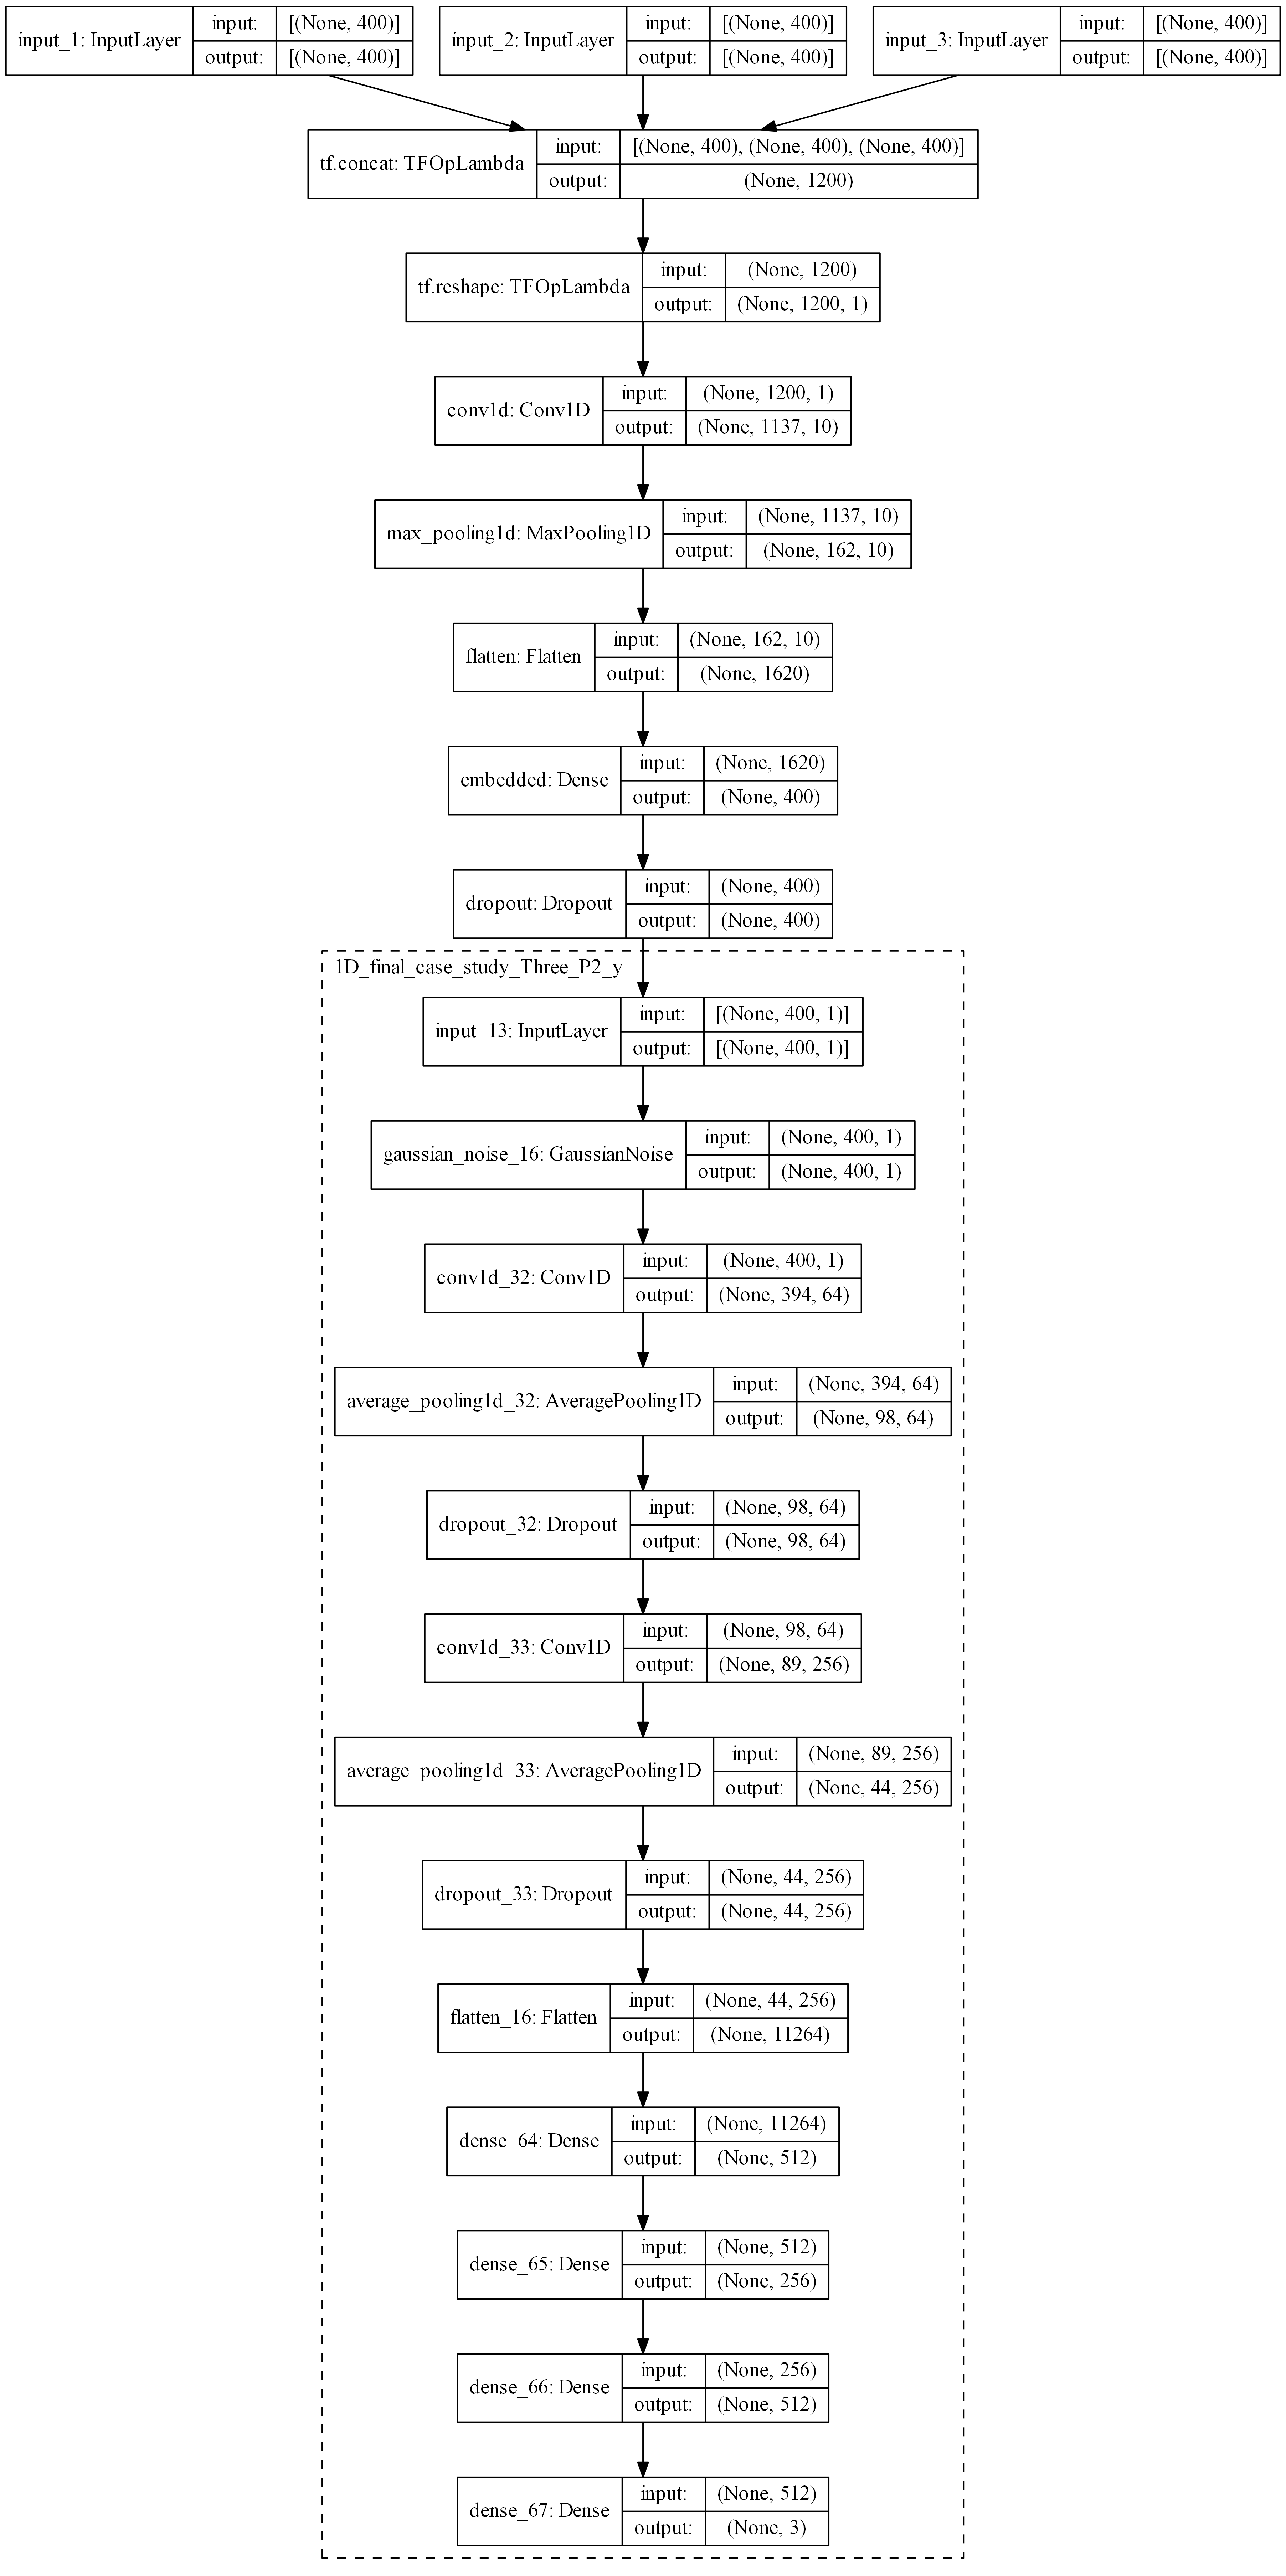

In [33]:
model_config = model.get_config()['layers']
text=''
for layer in model_config:
    classname=layer['class_name']
    try:
        name=layer['name']
    except:
        name=layer['config']['name']
    config = layer['config']
    print('-'*20,'(',classname,'\t',name,')','-'*20)
    text+='-'*20+'('+classname+'\t'+name+')'+'-'*20+'\n'
    for key,value in config.items():    
        if value==None or key=='name' or key=='trainable' or key=='dtype':
            continue
        print(key,'\t',value)
        text+=key+'\t'+str(value)+'\n'
f=open('{}/hyperparameters.txt'.format(model_name_to_load),'w')  
f.write(text)
f.close()

tf.keras.utils.plot_model(model,to_file="{}/architecture.png".format(model_name_to_load),show_layer_names=True,dpi=300,show_shapes=True,expand_nested=True)

# History

In [49]:
import csv
import pathlib
from pprint import pprint
his=pd.read_csv('{}/history.csv'.format(model_name_to_save))
print("total epochs:",len(his['epoch']))
his

total epochs: 100


,epoch,loss,lr,mean_squared_error,val_loss,val_mean_squared_error
0,0,23823.984375,0.001,23033.679688,16607.232422,15817.397461
1,1,13676.880859,0.001,12886.917969,13988.485352,13198.397461
2,2,10321.778320,0.001,9531.429688,9502.880859,8712.250977
3,3,8296.785156,0.001,7505.932617,9400.031250,8608.892578
4,4,6891.867676,0.001,6100.417480,7995.008301,7203.216309
...,...,...,...,...,...,...
95,95,1562.988159,0.001,724.214294,5047.540039,4208.479492
96,96,1539.974365,0.001,700.700867,4980.939941,4141.522461
97,97,1555.140625,0.001,715.530029,5103.257324,4263.254395
98,98,1542.291260,0.001,701.894897,5499.583984,4658.880371


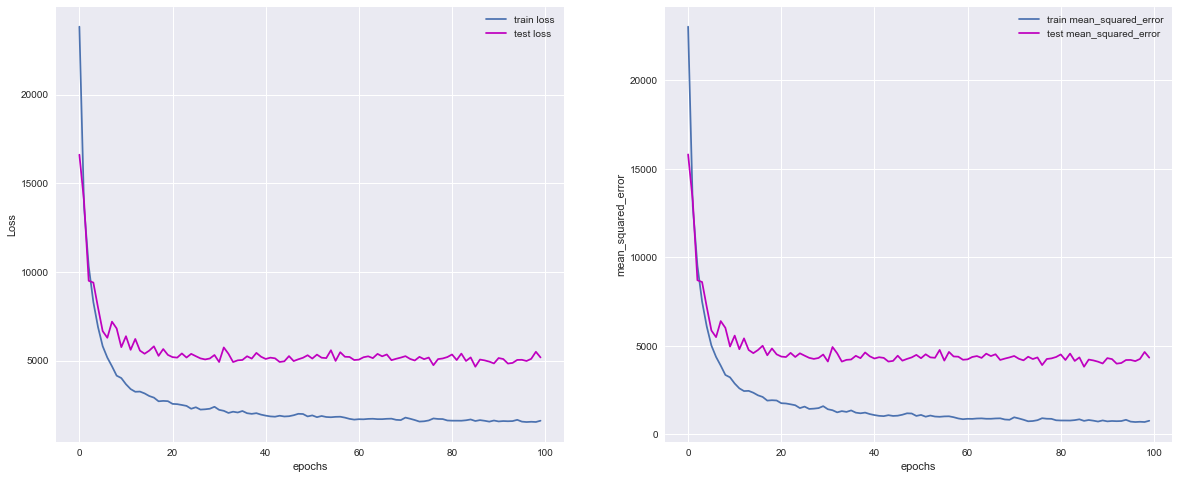

In [50]:
plt.figure(1,figsize=(20,8))
plt.subplot(1,2,1)
plt.xlabel("epochs")
plt.ylabel("Loss")
try:
    plt.plot(his['X_loss'], label = 'X train loss')
    plt.plot(his['val_X_loss'], label = 'X test loss')
    plt.plot(his['Y_loss'], label = 'Y train loss')
    plt.plot(his['val_Y_loss'], label = 'Y test loss')
    plt.plot(his['Z_loss'], label = 'Z train loss')
    plt.plot(his['val_Z_loss'], label = 'Z test loss')
except:
    plt.plot(his['loss'], label = 'train loss')
    plt.plot(his['val_loss'], label = 'test loss',color='m')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("epochs")
try:
    plt.ylabel('mean_squared_error')
    plt.plot(his['X_mean_squared_error'], label = 'X train mean_squared_error')
    plt.plot(his['val_X_mean_squared_error'], label = 'X test mean_squared_error' )
    plt.plot(his['Y_mean_squared_error'], label = 'Y train mean_squared_error')
    plt.plot(his['val_Y_mean_squared_error'], label = 'Y test mean_squared_error' )
    plt.plot(his['Z_mean_squared_error'], label = 'Z train mean_squared_error')
    plt.plot(his['val_Z_mean_squared_error'], label = 'Z test mean_squared_error' )
except:
    plt.ylabel('mean_squared_error')
    plt.plot(his['mean_squared_error'], label = 'train mean_squared_error')
    plt.plot(his['val_mean_squared_error'], label = 'test mean_squared_error',color='m' )
plt.grid(True)
plt.legend()
plt.savefig('{}/graph.png'.format(model_name_to_load))

# Save model

In [31]:
model.save_weights('{}/weights_only.h5'.format(model_name_to_save)) #1 reserved
model.save('{}/model.h5'.format(model_name_to_save),include_optimizer=True,overwrite=True)

# Test

In [51]:
import math
import statistics

c,c2,index=0,0,0
errors={}
validation={}
poly_space=[] 
l=model.predict([X_test_x,X_test_y,X_test_z])     
for val in l:
    x,y,z=val[0],val[1],val[2]
    x2,y2,z2=y_test.to_numpy()[c2]
    validation[c]=[x,y,z,index,'predict']
    c+=1
    validation[c]=[x2,y2,z2,index,'actual']
    poly_space.append(math.sqrt((x2-500)**2+(y2-250)**2+(z2-250)**2))
    c+=1
    c2+=1
    index+=1
    errors[c]=math.sqrt((1/3)*((x2-x)**2+(y2-y)**2+(z2-z)**2))

validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','index','kind'])
validation.to_csv("{}/prediction_per_actual.csv".format(model_name_to_load),index=False)

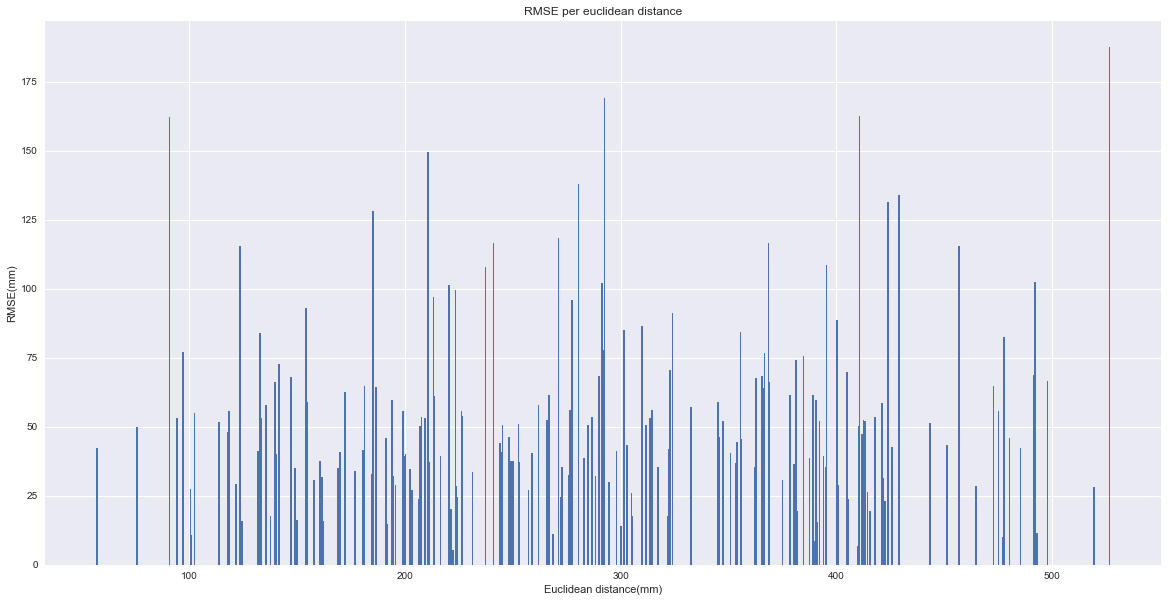

In [52]:
plt.figure(1,figsize=(20,10))
plt.title("RMSE per euclidean distance")

plt.bar(poly_space,list(errors.values()))
plt.ylabel("RMSE(mm)")
plt.xlabel("Euclidean distance(mm)")

plt.savefig('{}/Euclidean_distance.png'.format(model_name_to_load))

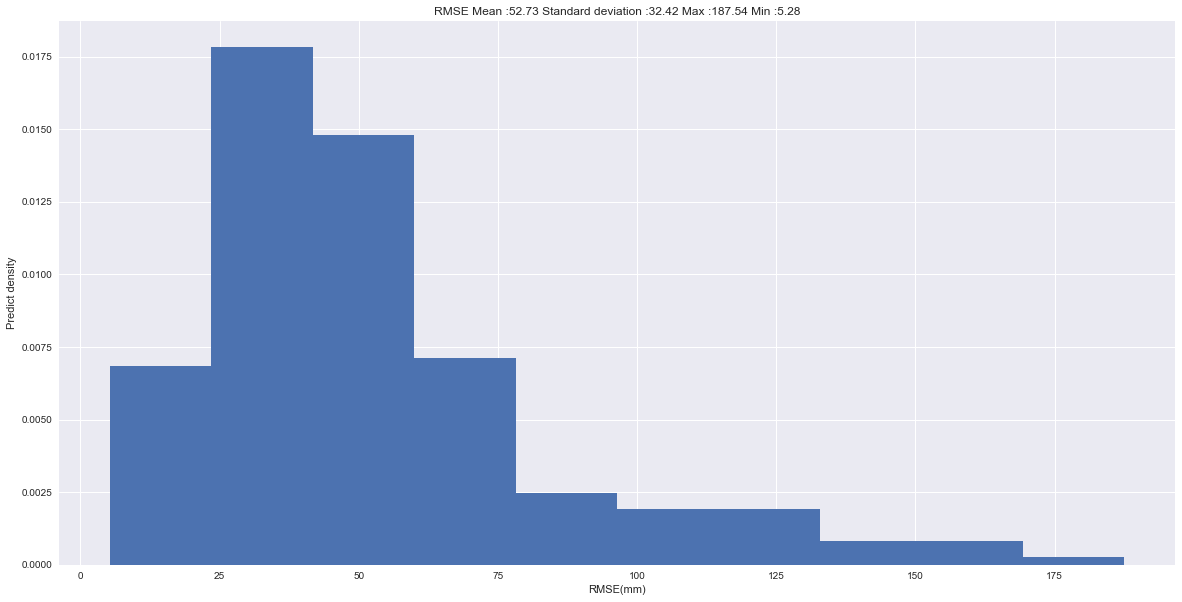

In [53]:
plt.figure(1,figsize=(20,10))
values=list(errors.values())
m=round(np.mean(values),2)
sd=round(statistics.stdev(values),2)
maximum=round(np.max(values),2)
minimum=round(np.min(values),2)
plt.title("RMSE Mean :{} Standard deviation :{} Max :{} Min :{}".format(m,sd,maximum,minimum))

plt.hist(values, density=True)
plt.ylabel("Predict density")
plt.xlabel("RMSE(mm)")

plt.savefig('{}/losses.png'.format(model_name_to_load))

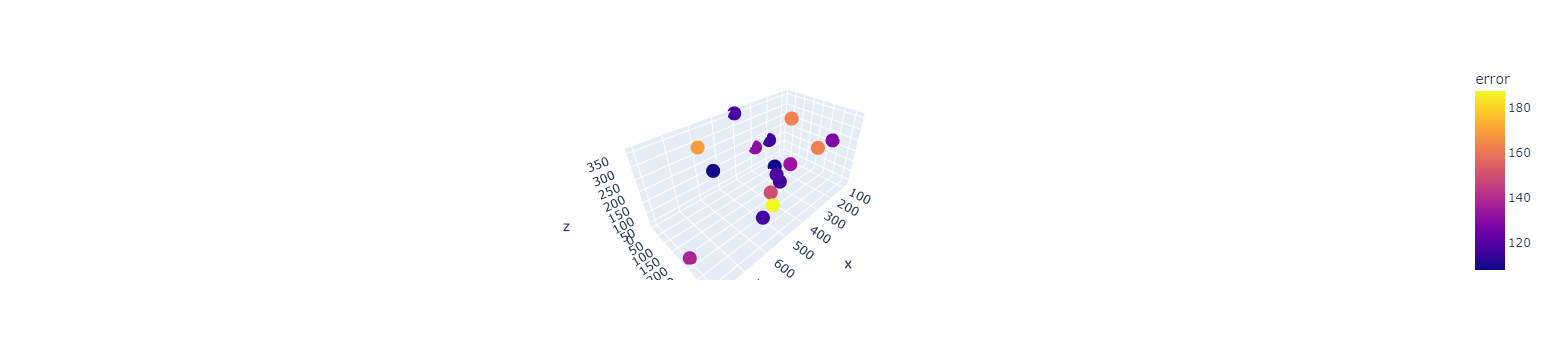

aboves : 16


In [54]:
import plotly.express as px
i,c=1,0
Validation={}
for k in list(errors.values()):
    if k > m*2:
        #print('x:',validation.iloc[i]['x'],'y:',validation.iloc[i]['y'],'z:',validation.iloc[i]['z'],'error:',k,'\n')
        Validation[c]=[validation.iloc[i]['x'],validation.iloc[i]['y'],validation.iloc[i]['z'],k]
        i=i+2
        c+=1
Validation=pd.DataFrame.from_dict(Validation, orient='index',columns=['x','y','z','error'])        
fig = px.scatter_3d(Validation,x="x", y="y", z="z",color='error')        
fig.show()        
print("aboves :",c)        

In [55]:
validation[0:10]

,x,y,z,index,kind
0,771.707153,120.353798,54.250912,0,predict
1,799.221957,226.737399,40.523400,0,actual
2,315.678223,199.470154,96.286263,1,predict
3,354.395760,222.105594,110.792365,1,actual
4,549.361816,56.466209,217.012482,2,predict
5,593.682776,110.080424,228.433785,2,actual
6,431.654297,154.081100,169.245422,3,predict
7,400.907295,10.696284,357.592530,3,actual
8,58.883240,280.154327,239.910461,4,predict
9,86.369255,281.411436,220.652136,4,actual


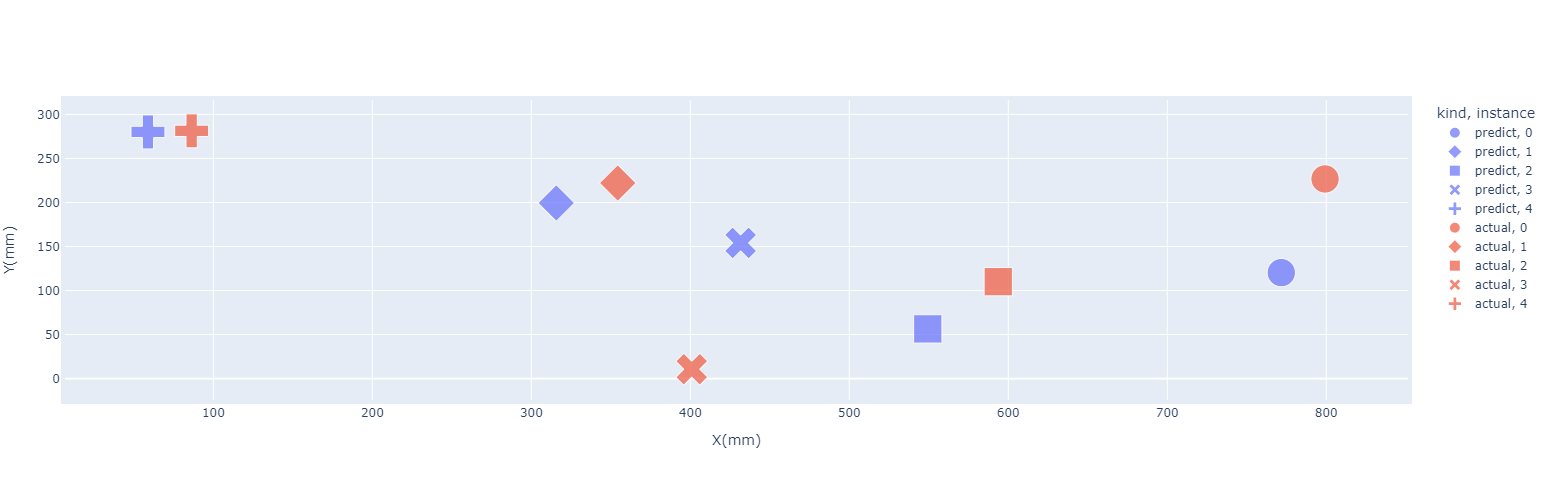

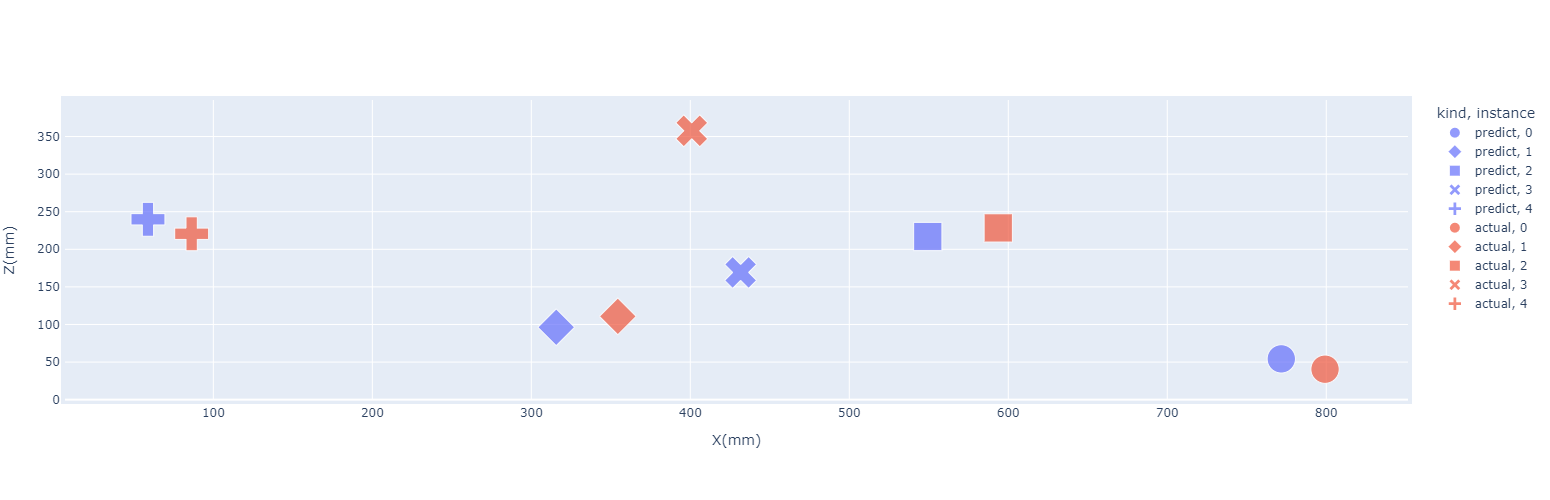

In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


fig=px.scatter(data_frame = validation[0:10]
            ,x = 'x'
            ,y = 'y'
            ,color = 'kind'
            ,symbol="index"  
            ,size=[10,10,10,10,10,10,10,10,10,10] 
            ,labels={
                     "x": "X(mm)",
                     "y": "Y(mm)",
                     "kind": "kind",
                     "index":"instance"
                 },
           )
fig.update_layout(
    autosize=True,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)

fig.show()
fig.write_image("{}/YX.png".format(model_name_to_load))
fig=px.scatter(data_frame = validation[0:10]
            ,x = 'x'
            ,y = 'z'
            ,color = 'kind'
            ,symbol="index" 
            ,size=[10,10,10,10,10,10,10,10,10,10] 
            ,labels={
                     "x": "X(mm)",
                     "z": "Z(mm)",
                     "kind": "kind",
                     "index":"instance"
                 },
           )
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)
fig.show()
fig.write_image("{}/ZX.png".format(model_name_to_load))

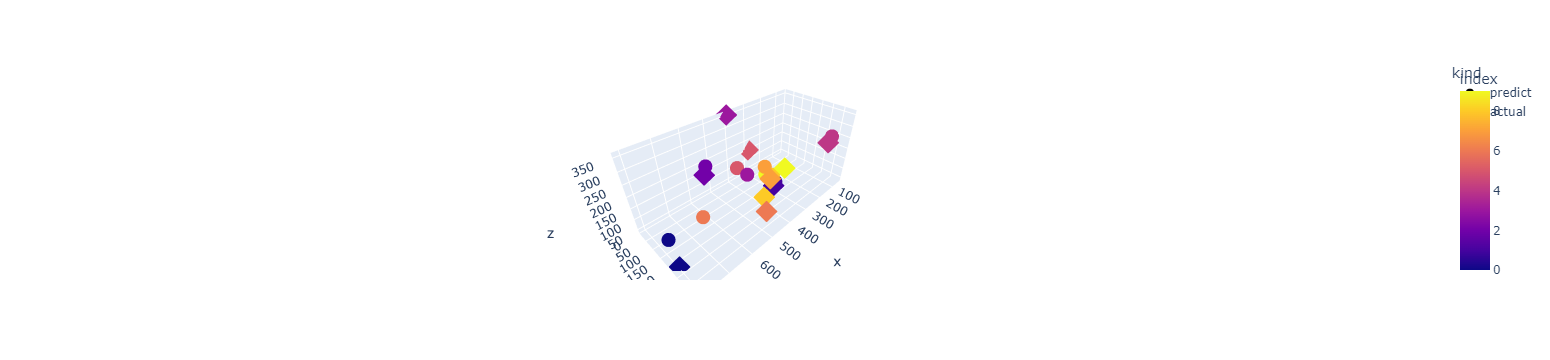

In [57]:
import plotly.express as px
fig = px.scatter_3d(validation[0:20],x="x", y="y", z="z",color='index', symbol='kind')
fig.show()

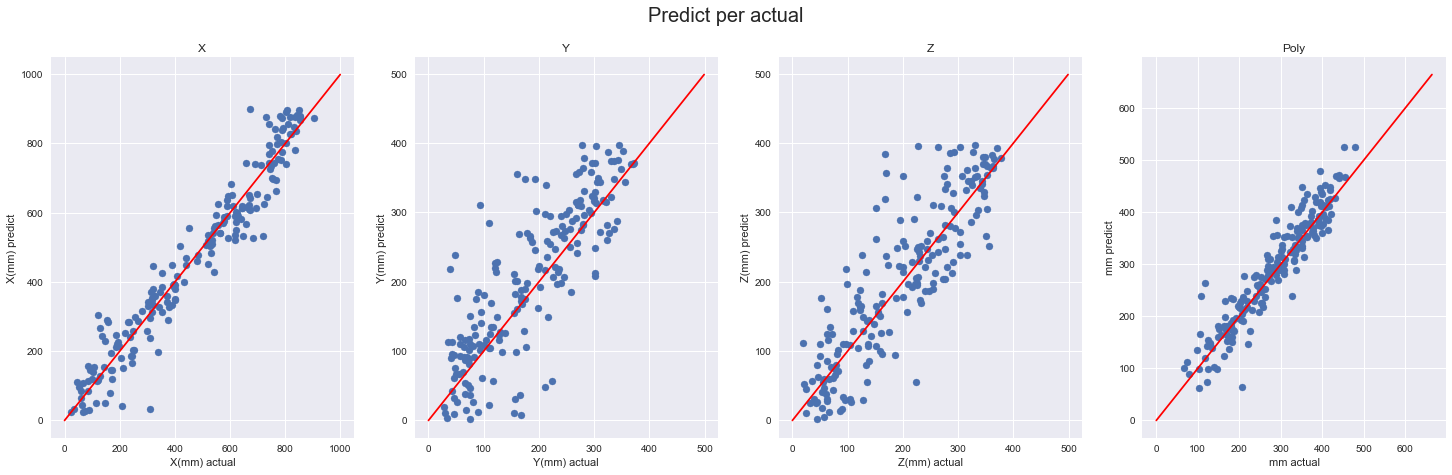

In [58]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(25,7))
plt.suptitle( 'Predict per actual', fontsize=20)
plt.rcParams.update({'font.size':15})

plt.subplot(1,4,1)
plt.title('X')
plt.ylabel("X(mm) predict")
plt.xlabel("X(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['x'] , validation[validation['kind'] == 'actual']['x'])
plt.plot(range(0,1000),range(0,1000),"r")
plt.grid(True)

plt.subplot(1,4,2)
plt.title('Y')
plt.ylabel("Y(mm) predict")
plt.xlabel("Y(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['y'] , validation[validation['kind'] == 'actual']['y'])
plt.plot(range(0,500),range(0,500),"r")
plt.grid(True)

plt.subplot(1,4,3)
plt.title('Z')
plt.ylabel("Z(mm) predict")
plt.xlabel("Z(mm) actual")
plt.scatter(validation[validation['kind'] == 'predict']['z'], validation[validation['kind'] == 'actual']['z'])
plt.plot(range(0,500),range(0,500),"r")
plt.grid(True)

plt.subplot(1,4,4)
plt.title('Poly')
plt.ylabel("mm predict")
plt.xlabel("mm actual")
plt.scatter((validation[validation['kind'] == 'predict']['x']+validation[validation['kind'] == 'predict']['y']+validation[validation['kind'] == 'predict']['z'])/3, (validation[validation['kind'] == 'actual']['x']+validation[validation['kind'] == 'actual']['y']+validation[validation['kind'] == 'actual']['z'])/3)

plt.plot(range(0,int((2000)/3)),range(0,int(2000/3)),"r")
plt.grid(True)

plt.savefig('{}/evaluate.png'.format(model_name_to_load))

In [59]:
print('X=',np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'actual']['x'])[0][1])

print('Y=',np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'actual']['y'])[0][1])

print("Z=",np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'actual']['z'])[0][1])


X= 0.9679456999954082
Y= 0.8327739787058631
Z= 0.8668256102390492
